In [1]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn import cross_validation
from sklearn.cross_validation import LabelKFold

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
LUNA16_FEAT_FILE = '/Users/ashishshah/Documents/kaggle/data_science_bowl_3/features/luna16_classifier_feats_fc512_stage2.csv'

df = pd.read_csv(LUNA16_FEAT_FILE)
print ("number of rows", df.shape)
#df.head()

number of rows (2101, 529)


In [3]:
SIMPLE_FEAT_FILE = '/Users/ashishshah/Documents/kaggle/data_science_bowl_3/features/simple_features_stage2.csv'
df_simple_feat = pd.read_csv(SIMPLE_FEAT_FILE)
df_simple_feat.drop('cancer', axis=1, inplace=True)
print ("number of rows", len(df_simple_feat))

df = pd.merge(df, df_simple_feat, on='id', how='left')
print ("number of rows", df.shape)
#df.head()

number of rows 2101
number of rows (2101, 535)


In [4]:
RESNET_FEAT_FILE = '/Users/ashishshah/Documents/kaggle/data_science_bowl_3/features/resenet_feats50_2_mean_stage2.csv'
#RESNET_FEAT_FILE = '/notebooks/ashish/features_csv/resenet_feats50_2_mean_std_stage2.csv'

df_resnet = pd.read_csv(RESNET_FEAT_FILE)
print ("number of rows", df_resnet.shape)

## combine feature from two different dataframes
df = pd.merge(df, df_resnet, on='id', how='left')
print ("number of rows", df.shape)
#df.head()

number of rows (2101, 2049)
number of rows (2101, 2583)


In [5]:
LABEL_FILE = '/Users/ashishshah/Documents/kaggle/data_science_bowl_3/input/stage2_labels.csv'
#LABEL_FILE = '/Users/ashishshah/Documents/kaggle/data_science_bowl_3/input/stage1_labels.csv'
df_label = pd.read_csv(LABEL_FILE)
print ("df_label", df_label.shape)

df_train = pd.merge(df_label, df, how='left', on='id')

print ("df_train", df_train.shape)
#df_train.head()

df_label (1595, 2)
df_train (1595, 2584)


In [6]:
## training data
feat_cols = [col for col in df_train.columns if col not in ['id', 'cancer']]
x = df_train[feat_cols].values
y = df_train['cancer'].values

## kfold strategy
skFolds = StratifiedKFold(n_splits=5, random_state=1234)

## start off with high learning rate and high number of estimators

In [7]:
param_tests = { }

estimator = XGBClassifier(
                      n_estimators=1000,
                      learning_rate=0.05,  
                      max_depth=3,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=1, 
                      scale_pos_weight=1, 
                      seed=57226)

gsearch1 = GridSearchCV(estimator = estimator, 
                        param_grid = param_tests, 
                        scoring='neg_log_loss',
                        n_jobs=6,
                        iid=False, 
                        cv=skFolds
                        )

gsearch1.fit(x, y)

print(gsearch1.grid_scores_)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

[mean: -0.74103, std: 0.07344, params: {}]
{}
-0.741030278599


/opt/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


## figure out how many estimators do you really need

In [21]:
def check_performance(bst, x, y, skFolds, early_stopping_num=100):
    xgb_param = bst.get_xgb_params()
    xgtrain = xgb.DMatrix(x, label=y)

    cvresult = xgb.cv(xgb_param, xgtrain, 
                      num_boost_round=bst.get_params()['n_estimators'], 
                      folds=skFolds,
                      metrics='logloss', 
                      #stratified=True,
                      early_stopping_rounds=early_stopping_num,
                      seed=57226)

    cvresult[['test-logloss-mean', 'train-logloss-mean']].plot()
    print ("Early stopping at iteration %d" % len(cvresult))
    print (cvresult.iloc[-1]) 
    
    return len(cvresult), cvresult

Early stopping at iteration 48
test-logloss-mean     0.545936
test-logloss-std      0.011704
train-logloss-mean    0.401750
train-logloss-std     0.011667
Name: 47, dtype: float64


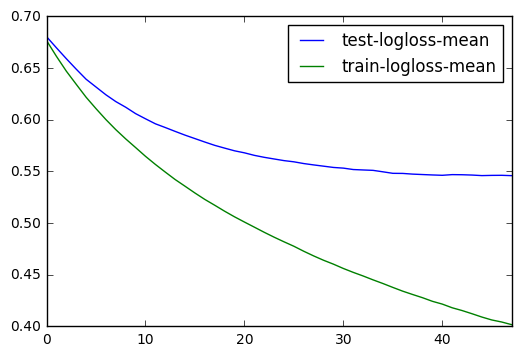

In [22]:
best_n_est, cvresult = check_performance(gsearch1.best_estimator_, x, y, skFolds)

## grid search for min_depth and min_child_weight params for fixed learning rate

In [15]:
estimator = XGBClassifier(
                      n_estimators=best_n_est,
                      learning_rate=0.05,  
                      max_depth=3,
                      min_child_weight=1, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=1, 
                      scale_pos_weight=1, 
                      seed=57226)


param_tests = {
                 'max_depth': [3,4,5,6,7],
                 'min_child_weight': [1,2,3]
               }

gsearch2 = GridSearchCV(estimator = estimator, 
                        param_grid = param_tests, 
                        scoring='neg_log_loss',
                        n_jobs=6,
                        iid=False, 
                        cv=skFolds
                        )
gsearch2.fit(x, y)

for gs in gsearch2.grid_scores_:
    print (gs)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

mean: -0.54611, std: 0.01860, params: {'min_child_weight': 1, 'max_depth': 3}
mean: -0.54798, std: 0.01821, params: {'min_child_weight': 2, 'max_depth': 3}
mean: -0.54661, std: 0.01613, params: {'min_child_weight': 3, 'max_depth': 3}
mean: -0.54448, std: 0.01767, params: {'min_child_weight': 1, 'max_depth': 4}
mean: -0.54569, std: 0.01744, params: {'min_child_weight': 2, 'max_depth': 4}
mean: -0.54563, std: 0.02008, params: {'min_child_weight': 3, 'max_depth': 4}
mean: -0.54547, std: 0.02118, params: {'min_child_weight': 1, 'max_depth': 5}
mean: -0.54657, std: 0.02149, params: {'min_child_weight': 2, 'max_depth': 5}
mean: -0.54637, std: 0.02185, params: {'min_child_weight': 3, 'max_depth': 5}
mean: -0.54145, std: 0.02118, params: {'min_child_weight': 1, 'max_depth': 6}
mean: -0.54624, std: 0.02400, params: {'min_child_weight': 2, 'max_depth': 6}
mean: -0.54865, std: 0.02169, params: {'min_child_weight': 3, 'max_depth': 6}
mean: -0.55035, std: 0.02075, params: {'min_child_weight': 1, 'm

/opt/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


## grid search for gamma 

In [16]:
best_min_child = 1
best_max_depth = 6
estimator = XGBClassifier(
                      n_estimators=best_n_est,
                      learning_rate=0.05,  
                      max_depth=best_max_depth,
                      min_child_weight=best_min_child, 
                      gamma=0, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=1, 
                      scale_pos_weight=1, 
                      seed=57226)


param_tests = {
                'gamma':[i/10.0 for i in range(0,5)]
               }

gsearch3 = GridSearchCV(estimator = estimator, 
                        param_grid = param_tests, 
                        scoring='neg_log_loss',
                        n_jobs=6,
                        iid=False, 
                        cv=skFolds
                        )
gsearch3.fit(x, y)

for gs in gsearch3.grid_scores_:
    print (gs)
print(gsearch3.best_params_)
print(gsearch3.best_score_)

mean: -0.54145, std: 0.02118, params: {'gamma': 0.0}
mean: -0.54822, std: 0.02463, params: {'gamma': 0.1}
mean: -0.54830, std: 0.02344, params: {'gamma': 0.2}
mean: -0.54892, std: 0.02328, params: {'gamma': 0.3}
mean: -0.54228, std: 0.02445, params: {'gamma': 0.4}
{'gamma': 0.0}
-0.541448228992


/opt/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Early stopping at iteration 48
test-logloss-mean     0.548990
test-logloss-std      0.017069
train-logloss-mean    0.214142
train-logloss-std     0.010114
Name: 47, dtype: float64


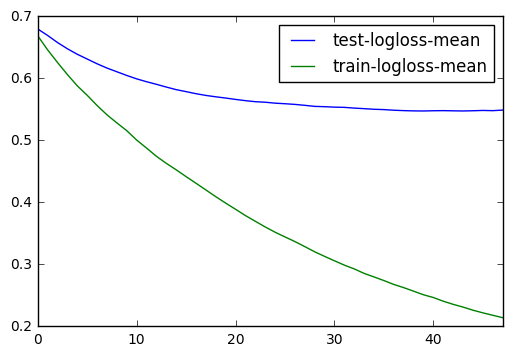

In [23]:
best_n_est, cvresult = check_performance(gsearch3.best_estimator_, x, y, skFolds)

## grid search for subsample and colsample_bytree parameer

In [24]:
best_min_child = 1
best_max_depth = 6
best_gamma = 0
estimator = XGBClassifier(
                      n_estimators=best_n_est,
                      learning_rate=0.05,  
                      max_depth=best_max_depth,
                      min_child_weight=best_min_child, 
                      gamma=best_gamma, 
                      subsample=0.8, 
                      colsample_bytree=0.8,
                      objective= 'binary:logistic', 
                      nthread=1, 
                      scale_pos_weight=1, 
                      seed=57226)


param_tests = {
                 'subsample':[i/10.0 for i in range(6,10)],
                 'colsample_bytree':[i/10.0 for i in range(6,10)]
                  #'subsample':[i/100.0 for i in range(75,90,5)],  ## finer grid
                 #'colsample_bytree':[i/100.0 for i in range(75,90,5)]
               }

gsearch4 = GridSearchCV(estimator = estimator, 
                        param_grid = param_tests, 
                        scoring='neg_log_loss',
                        n_jobs=6,
                        iid=False, 
                        cv=skFolds
                        )
gsearch4.fit(x, y)

for gs in gsearch4.grid_scores_:
    print (gs)
print(gsearch4.best_params_)
print(gsearch4.best_score_)

mean: -0.54867, std: 0.01877, params: {'colsample_bytree': 0.6, 'subsample': 0.6}
mean: -0.55663, std: 0.02204, params: {'colsample_bytree': 0.6, 'subsample': 0.7}
mean: -0.55212, std: 0.02035, params: {'colsample_bytree': 0.6, 'subsample': 0.8}
mean: -0.55195, std: 0.02072, params: {'colsample_bytree': 0.6, 'subsample': 0.9}
mean: -0.54935, std: 0.02100, params: {'colsample_bytree': 0.7, 'subsample': 0.6}
mean: -0.54885, std: 0.02135, params: {'colsample_bytree': 0.7, 'subsample': 0.7}
mean: -0.54941, std: 0.01987, params: {'colsample_bytree': 0.7, 'subsample': 0.8}
mean: -0.55710, std: 0.02094, params: {'colsample_bytree': 0.7, 'subsample': 0.9}
mean: -0.55296, std: 0.02153, params: {'colsample_bytree': 0.8, 'subsample': 0.6}
mean: -0.55112, std: 0.01843, params: {'colsample_bytree': 0.8, 'subsample': 0.7}
mean: -0.54145, std: 0.02118, params: {'colsample_bytree': 0.8, 'subsample': 0.8}
mean: -0.55096, std: 0.02048, params: {'colsample_bytree': 0.8, 'subsample': 0.9}
mean: -0.55240, 

/opt/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


## grid search for reg_alpha param

In [27]:
best_min_child = 1
best_max_depth = 6
best_gamma = 0
best_subsample = 0.8
best_colsample_bytree = 0.8

estimator = XGBClassifier(
                      n_estimators=best_n_est,
                      learning_rate=0.05,  
                      max_depth=best_max_depth,
                      min_child_weight=best_min_child, 
                      gamma=best_gamma, 
                      subsample=best_subsample, 
                      colsample_bytree=best_colsample_bytree,
                      objective= 'binary:logistic', 
                      nthread=1, 
                      scale_pos_weight=1, 
                      seed=57226)


param_tests = {
                #'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
                'reg_alpha':[1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
               }

gsearch5 = GridSearchCV(estimator = estimator, 
                        param_grid = param_tests, 
                        scoring='neg_log_loss',
                        n_jobs=6,
                        iid=False, 
                        cv=skFolds
                        )
gsearch5.fit(x, y)

for gs in gsearch5.grid_scores_:
    print (gs)
print(gsearch5.best_params_)
print(gsearch5.best_score_)

mean: -0.54145, std: 0.02118, params: {'reg_alpha': 1e-07}
mean: -0.54145, std: 0.02118, params: {'reg_alpha': 1e-06}
mean: -0.54145, std: 0.02118, params: {'reg_alpha': 1e-05}
mean: -0.54145, std: 0.02118, params: {'reg_alpha': 0.0001}
mean: -0.54345, std: 0.02062, params: {'reg_alpha': 0.001}
{'reg_alpha': 0.0001}
-0.541448137918


/opt/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Early stopping at iteration 48
test-logloss-mean     0.548990
test-logloss-std      0.017069
train-logloss-mean    0.214144
train-logloss-std     0.010113
Name: 47, dtype: float64


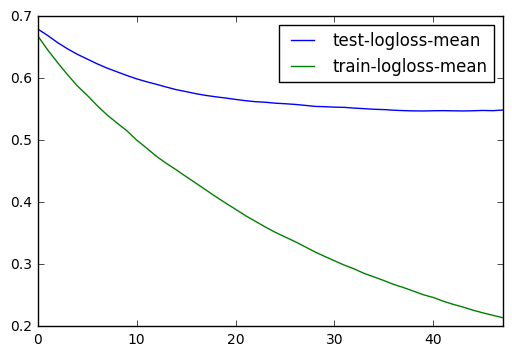

In [28]:
best_n_est, cvresult = check_performance(gsearch5.best_estimator_, x, y, skFolds)

## Final model with optimal parameters

Early stopping at iteration 424
test-logloss-mean     0.543507
test-logloss-std      0.014710
train-logloss-mean    0.237072
train-logloss-std     0.013199
Name: 423, dtype: float64


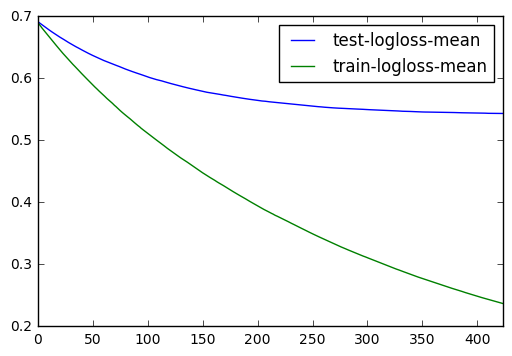

In [37]:
learning_rate = 0.005
best_min_child = 1
best_max_depth = 6
best_gamma = 0
best_subsample = 0.8
best_colsample_bytree = 0.8
best_reg_alpha = 0.0001

estimator = XGBClassifier(
                      n_estimators=1000,
                      learning_rate=learning_rate,  
                      max_depth=best_max_depth,
                      min_child_weight=best_min_child, 
                      gamma=best_gamma, 
                      subsample=best_subsample, 
                      colsample_bytree=best_colsample_bytree,
                      reg_alpha=best_reg_alpha,
                      objective='binary:logistic', 
                      nthread=1, 
                      scale_pos_weight=1, 
                      seed=57226)

best_n_est, cvresult = check_performance(estimator, x, y, skFolds)

In [46]:
## save the model off to a file
num_estimator = 47
learning_rate = 0.005
best_min_child = 1
best_max_depth = 6
best_gamma = 0
best_subsample = 0.8
best_colsample_bytree = 0.8
best_reg_alpha = 0.0001

estimator = XGBClassifier(
                      n_estimators=num_estimator,
                      learning_rate=learning_rate,  
                      max_depth=best_max_depth,
                      min_child_weight=best_min_child, 
                      gamma=best_gamma, 
                      subsample=best_subsample, 
                      colsample_bytree=best_colsample_bytree,
                      reg_alpha=best_reg_alpha,
                      objective='binary:logistic', 
                      nthread=1, 
                      scale_pos_weight=1, 
                      seed=57226)


model_file_name = 'best_gridCV_model.xgb'
pickle.dump(estimator, open(model_file_name, "wb"))

## Feature Ranking!

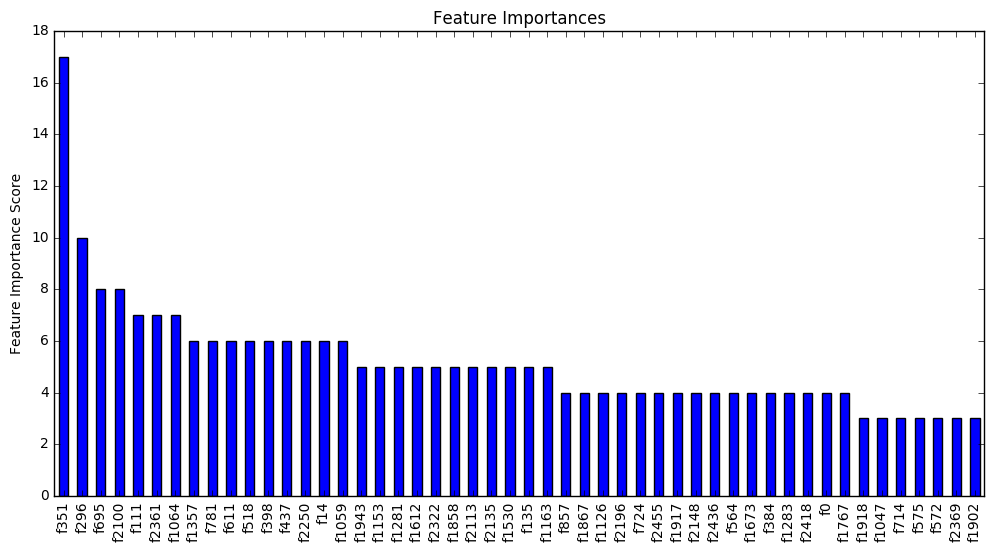

In [35]:
feat_imp = pd.Series(gsearch5.best_estimator_.booster().get_fscore()).sort_values(ascending=False)[:50]
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,6))
plt.ylabel('Feature Importance Score')

In [49]:
learning_rate = 0.05 #0.001
n_estimators = 40 #2000
best_min_child = 1
best_max_depth = 6
best_gamma = 0
best_subsample = 0.8
best_colsample_bytree = 0.8
best_reg_alpha = 0.0001

estimator = XGBClassifier(
                      n_estimators=n_estimators,
                      learning_rate=learning_rate,  
                      max_depth=best_max_depth,
                      min_child_weight=best_min_child, 
                      gamma=best_gamma, 
                      subsample=best_subsample, 
                      colsample_bytree=best_colsample_bytree,
                      reg_alpha=best_reg_alpha,
                      objective='binary:logistic', 
                      nthread=1, 
                      scale_pos_weight=1, 
                      seed=57226)

#best_n_est, cvresult = check_performance(estimator, x, y, skFolds)

In [50]:
model_file_name = 'best_gridCV_model_simple.xgb'
pickle.dump(estimator, open(model_file_name, "wb"))